# Autoregressive models - PixelCNNs blind spot in the receptive field and how to fix it 

In our previous notebooks, we trained a generative model to create black and white drawings of numbers and to generate coloured images. Now we are going to look into the blind splot, one of the biggest drawbacks of the PixelCNNs, and how to fix it. We will also define the Gated PixelCNN and analyse its performance on the MNIST dataset.

This implementation uses Tensorflow 2.0. We start by installing and importing the code dependencies.

In [ ]:
%tensorflow_version 2.x

In [ ]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.ticker import FixedLocator
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import nn
from tensorflow.keras import initializers
from tensorflow.keras.utils import Progbar

tf.keras.backend.set_floatx('float32')

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Like in the previous notebooks we are defining the Convolutional layers with masks and the ResidualBlocks.  The Residual block is an important building block of Oord's seminal paper that originated the PixelCNN.

*Note: Here we removed the ReLU activations to not mess with the gradients while we are investigating them.

In [ ]:
class ResidualBlock(keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel recurrent
    neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
#         x = nn.relu(input_tensor)
#         x = self.conv2a(x)
        x = self.conv2a(input_tensor)

#         x = nn.relu(x)
        x = self.conv2b(x)

#         x = nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

## Blind Spots

As we saw above, the original PixelCNN had a problem with its masked convolution that lead to a blind spot. Given a specific pixel, the use of masked convolution was not able to capture the information of all previous pixels. As we can see in the image below, the information on *j* is never used to predict *m*; and the information from the pixels in yellow are not used to predict *q*.

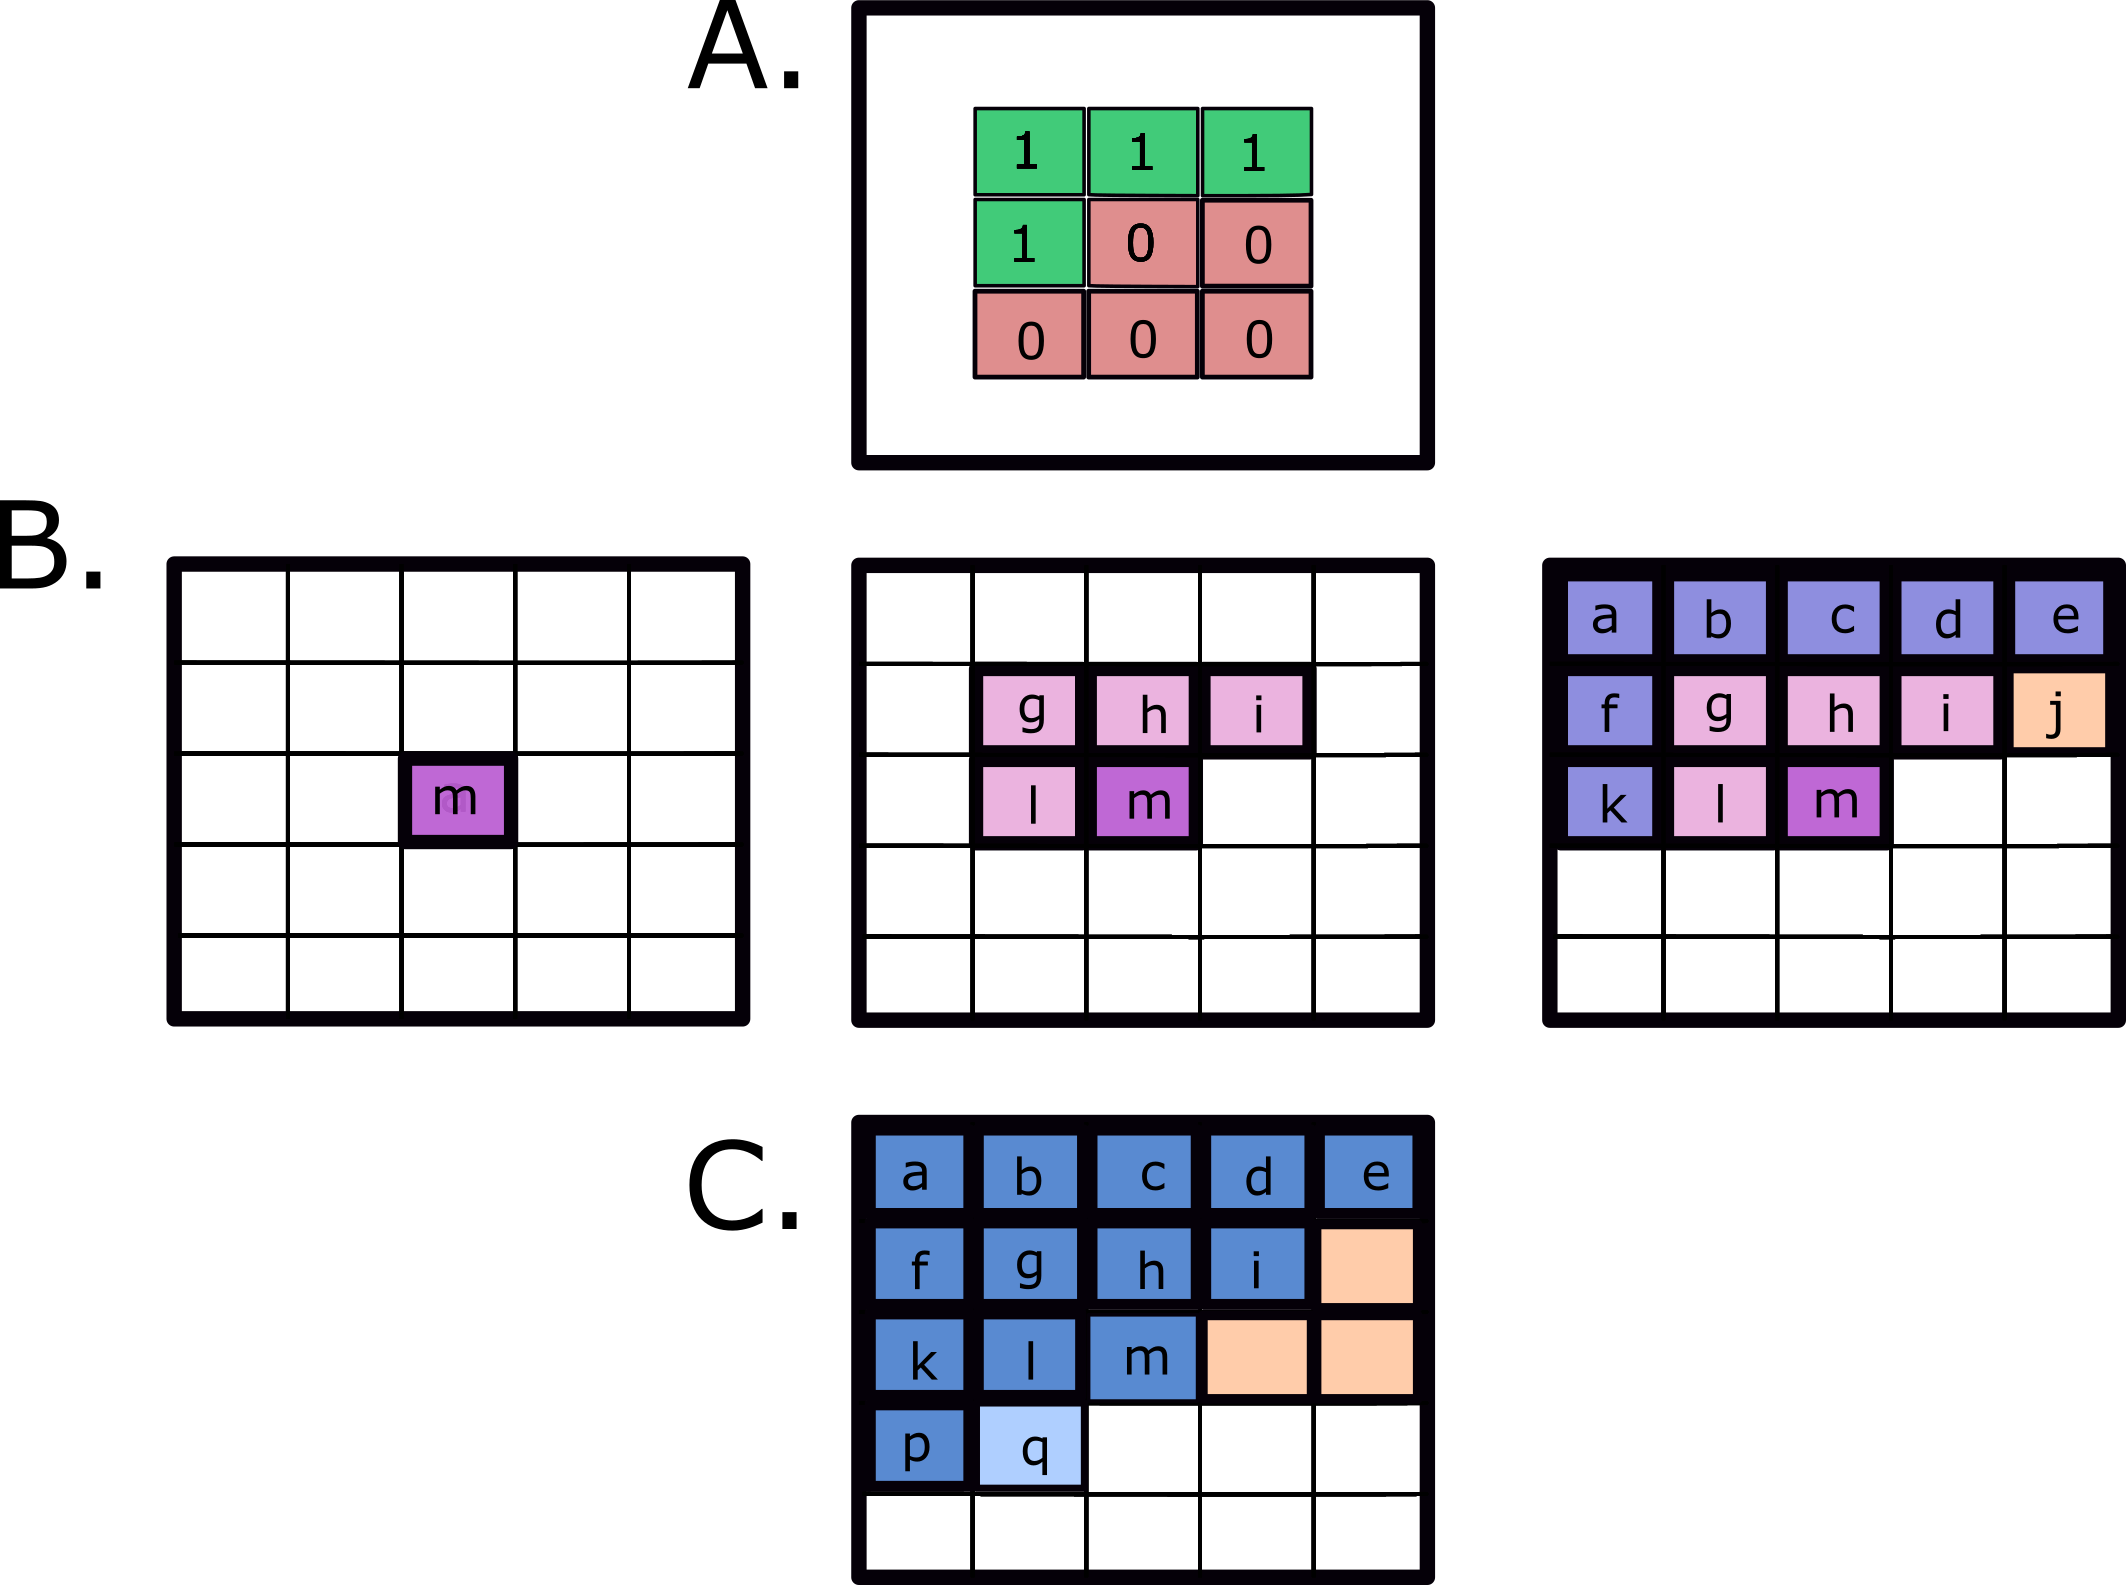

Let's start by implementing the convolution and looking at how the blind spot propagates. You should be familiar with the class below, as we have used it in the previous notebooks. 

In [ ]:
class MaskedConv2D(keras.layers.Layer):
    """Convolutional layers with masks.

    Convolutional layers with simple implementation of masks type A and B for
    autoregressive models.

    Arguments:
    mask_type: one of `"A"` or `"B".`
    filters: Integer, the dimensionality of the output space
        (i.e. the number of output filters in the convolution).
    kernel_size: An integer or tuple/list of 2 integers, specifying the
        height and width of the 2D convolution window.
        Can be a single integer to specify the same value for
        all spatial dimensions.
    strides: An integer or tuple/list of 2 integers,
        specifying the strides of the convolution along the height and width.
        Can be a single integer to specify the same value for
        all spatial dimensions.
        Specifying any stride value != 1 is incompatible with specifying
        any `dilation_rate` value != 1.
    padding: one of `"valid"` or `"same"` (case-insensitive).
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        self.kernel = self.add_weight('kernel',
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight('bias',
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        center = self.kernel_size // 2

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[center, center + (self.mask_type == 'B'):, :, :] = 0.
        mask[center + 1:, :, :, :] = 0.

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = nn.conv2d(input,
                      masked_kernel,
                      strides=[1, self.strides, self.strides, 1],
                      padding=self.padding)
        x = nn.bias_add(x, self.bias)
        return x

In [ ]:
def plot_receptive_field(model, data):
  """
  This function allows the visualisation of the receptive field
  """
  with tf.GradientTape() as tape:
      tape.watch(data)
      prediction = model(data)
      loss = prediction[:,5,5,0]

  gradients = tape.gradient(loss, data)

  gradients = np.abs(gradients.numpy().squeeze())
  gradients = (gradients > 0).astype('float32')
  gradients[5, 5] = 0.5

  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)

  plt.xticks(np.arange(0, 10, step=1))
  plt.yticks(np.arange(0, 10, step=1))
  ax.xaxis.set_minor_locator(FixedLocator(np.arange(0.5, 10.5, step=1)))
  ax.yaxis.set_minor_locator(FixedLocator(np.arange(0.5, 10.5, step=1)))
  plt.grid(which="minor")
  plt.imshow(gradients, vmin=0, vmax=1)
  plt.show()

In [ ]:
# --------------------------------------------------------------------------------------------------------------
height = 10
width = 10
n_channel = 1

data = tf.random.normal((1, height, width, n_channel))

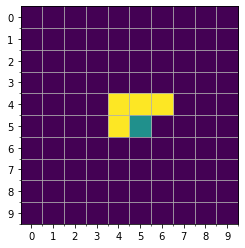

In [ ]:
# 1 layer PixelCNN
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=1, kernel_size=3, strides=1)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=x)

plot_receptive_field(model, data)


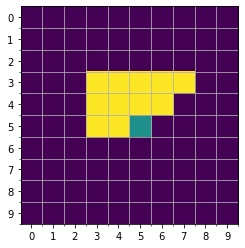

In [ ]:
# 2 layer PixelCNN
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=1, kernel_size=3, strides=1)(inputs)
x = ResidualBlock(h=1)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

plot_receptive_field(model, data)

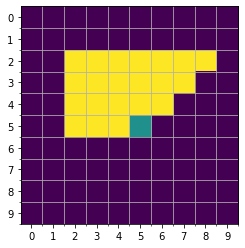

In [ ]:
# 3 layer PixelCNN
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=1, kernel_size=3, strides=1)(inputs)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

plot_receptive_field(model, data)

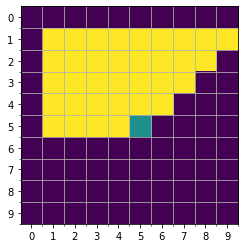

In [ ]:
# 4 layer PixelCNN
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=1, kernel_size=3, strides=1)(inputs)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

plot_receptive_field(model, data)

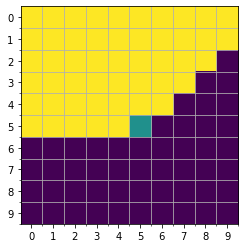

In [ ]:
# 5 layer PixelCNN
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=1, kernel_size=3, strides=1)(inputs)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

plot_receptive_field(model, data)

## Gated Pixel CNN and the blind spot

A big drawback of PixelCNNs is the blind spot in the receptive field. This blind spot is a result of using a mask that gets propagated via convolution. To overcome the blind spot problem, the Gated Pixel CNN was introduced. This new model solved the blind spot by using two separate convolutions (i.e., the horizontal and the vertical stack). 
While the horizontal stack consists of the pixels just before the predicted pixel, the vertical stack represents the rows above the predicted pixel.



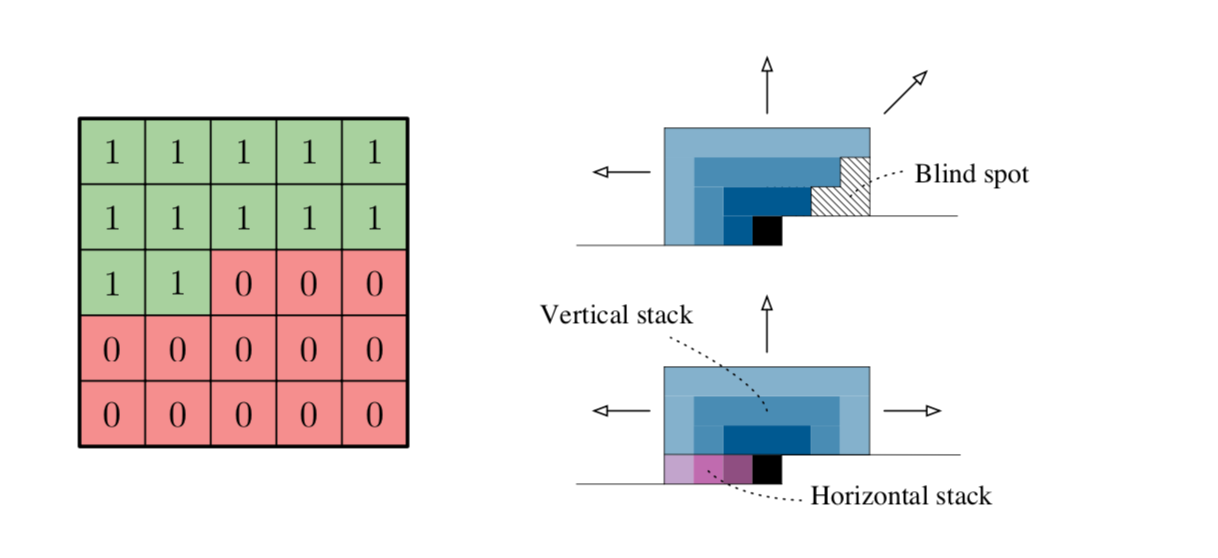

Let's re-implement the `MaskedConv2D` class, but now using the horizontal and vertical stack to correct for the blind spot.

In [ ]:
# --------------------------------------------------------------------------------------------------------------

class MaskedConv2D(keras.layers.Layer):
    """Convolutional layers with masks.

    Convolutional layers with simple implementation of masks type A and B for
    autoregressive models.

    Arguments:
    mask_type: one of `"A"` or `"B".`
    filters: Integer, the dimensionality of the output space
        (i.e. the number of output filters in the convolution).
    kernel_size: An integer or tuple/list of 2 integers, specifying the
        height and width of the 2D convolution window.
        Can be a single integer to specify the same value for
        all spatial dimensions.
    strides: An integer or tuple/list of 2 integers,
        specifying the strides of the convolution along the height and width.
        Can be a single integer to specify the same value for
        all spatial dimensions.
        Specifying any stride value != 1 is incompatible with specifying
        any `dilation_rate` value != 1.
    padding: one of `"valid"` or `"same"` (case-insensitive).
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B', 'V'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        kernel_h = self.kernel_size
        kernel_w = self.kernel_size
        self.kernel = self.add_weight('kernel',
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight('bias',
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)
        mask = np.ones(self.kernel.shape, dtype=np.float32)

        # Get centre of the filter for even or odd dimensions
        if kernel_h % 2 != 0:
            center_h = kernel_h // 2
        else:
            center_h = (kernel_h - 1) // 2

        if kernel_w % 2 != 0:
            center_w = kernel_w // 2
        else:
            center_w = (kernel_w - 1) // 2

        if self.mask_type == 'V':
            mask[center_h + 1:, :, :, :] = 0.
        else:
            mask[:center_h, :, :] = 0.
            mask[center_h, center_w + (self.mask_type == 'B'):, :, :] = 0.
            mask[center_h + 1:, :, :] = 0.

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = nn.conv2d(input,
                      masked_kernel,
                      strides=[1, self.strides, self.strides, 1],
                      padding=self.padding)
        x = nn.bias_add(x, self.bias)
        return x

In [ ]:
class GatedBlock(tf.keras.Model):
    """ Gated block that compose Gated PixelCNN."""

    def __init__(self, mask_type, filters, kernel_size):
        super(GatedBlock, self).__init__(name='')

        self.mask_type = mask_type
        self.vertical_conv = MaskedConv2D(mask_type='V',
                                          filters=2 * filters,
                                          kernel_size=kernel_size)

        self.horizontal_conv = MaskedConv2D(mask_type=mask_type,
                                            filters=2 * filters,
                                            kernel_size=kernel_size)

        self.padding = keras.layers.ZeroPadding2D(padding=((1, 0), 0))
        self.cropping = keras.layers.Cropping2D(cropping=((0, 1), 0))

        self.v_to_h_conv = keras.layers.Conv2D(filters=2 * filters, kernel_size=1)

        self.horizontal_output = keras.layers.Conv2D(filters=filters, kernel_size=1)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v = input_tensor[0]
        h = input_tensor[1]

        vertical_preactivation = self.vertical_conv(v)

        # Shifting vertical stack feature map down before feed into horizontal stack to
        # ensure causality
        v_to_h = self.padding(vertical_preactivation)
        v_to_h = self.cropping(v_to_h)
        v_to_h = self.v_to_h_conv(v_to_h)

        horizontal_preactivation = self.horizontal_conv(h)

        v_out = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        h_activated = self._gate(horizontal_preactivation)
        h_activated = self.horizontal_output(h_activated)

        if self.mask_type == 'A':
            h_out = h_activated
        elif self.mask_type == 'B':
            h_out = h + h_activated

        return v_out, h_out


In [ ]:
# Define the data
height = 10
width = 10
n_channel = 1

data = tf.random.normal((1, height, width, n_channel))

In [ ]:
# 1 layer Gated PixelCNN
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
model = tf.keras.Model(inputs=inputs, outputs=h)

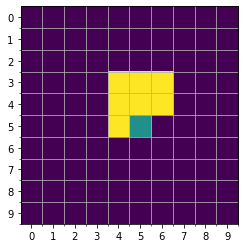

In [ ]:
plot_receptive_field(model, data)

Excellent! As expected, the block considered all the previous blocks in the same row of the analysed pixel and the two rows over it. Thus, the blind splot problem is fixed!

Note that the receptive field is different from the original PixelCNN. In the original PixelCNN, only one row over the analysed pixel influenced its prediction (when using one masked convolution). In the Gated PixelCNN, the authors used a vertical stack with an effective area of 2x3 per vertical convolution. This is not a problem since the considered pixels still being the ones in past positions. We believe the main choice for this format is to implement an efficient way to apply the masked convolutions without using masking (which we will discuss in future posts).

For the next step, we will verify a model with 2, 3, 4, and 5 layers.

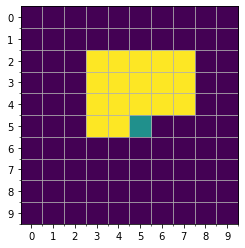

In [ ]:
# 2 layers Gated PixelCNN
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
model = tf.keras.Model(inputs=inputs, outputs=h)

plot_receptive_field(model, data)

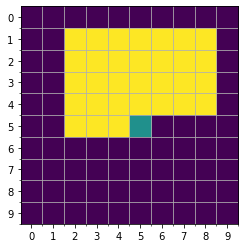

In [ ]:
# 3 layers Gated PixelCNN
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
model = tf.keras.Model(inputs=inputs, outputs=h)

plot_receptive_field(model, data)

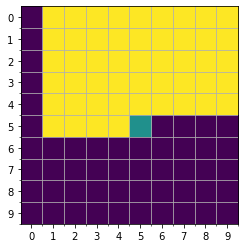

In [ ]:
# 4 layers Gated PixelCNN
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
model = tf.keras.Model(inputs=inputs, outputs=h)

plot_receptive_field(model, data)

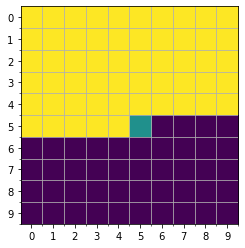

In [ ]:
# 5 layers Gated PixelCNN
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
model = tf.keras.Model(inputs=inputs, outputs=h)

plot_receptive_field(model, data)

As you can notice, the Gated PixelCNN does not create blind spots when adding more and more layers.

# Gated CNN 

We will now see how the Gated CNN works on real data (i.e., MNIST dataset). Finally, to make sure that this notebook is reproducible, we will fix the random seed.

This implementation is similar to the PixelCNN implementation we described in the [first notebook](https://colab.research.google.com/github/Mind-the-Pineapple/Autoregressive-models/blob/master/1%20-%20Autoregressive%20Models%20-%20PixelCNN/pixelCNN.ipynb#scrollTo=bU25WyouYYE3).


In [ ]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [ ]:
# Loading data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)

11501568/11490434 [==============================] - 0s 0us/step



In this example, to make the probability distribution of a single pixel easier to be defined, we decide to quantise the number of possible values that a pixel could have. Originally, in the MNIST dataset the pixels are represented by a uint8 variable, being able to assume values between [0, 255]. However, in this example, we restrict the image to have only 2 different values ([0, 1]).

In [ ]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [ ]:
# Quantise the input data in q levels
q_levels = 2
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

Using the `tensorflow.Data` API, we defined the input data streams for our model during the training and the evaluation. We define the inputs as the images with 2 levels normalized to be between [0, 1], and the target values are the categorical pixels values between [0, 1].

In [ ]:
# Creating input stream using tf.data API
batch_size = 192
train_buf = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

### PixelCNN architecture

In [ ]:
# Create Gated PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=64, kernel_size=3)([inputs, inputs])

for i in range(7):
    v, h = GatedBlock(mask_type='B', filters=64, kernel_size=3)([v, h])

x = keras.layers.Activation(activation='relu')(h)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=q_levels, kernel_size=1, strides=1)(x)

gated_pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

We use a simple Adam optimizer with learning rate decay to train the neural network. The loss function is defined by the cross-entropy (that, in this case, is equivalent to minimizing the negative log-likelihood of the training data).

In [ ]:
# Prepare optimizer and loss function
lr_decay = 0.999995
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

compute_loss = keras.losses.CategoricalCrossentropy(from_logits=True)


The training step is defined by the forward propagation through the model. Then, the gradients are calculated, clipped to be between [-1, 1], and applied to upgrade the PixelCNN parameters.

In [ ]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = gated_pixelcnn(batch_x, training=True)

        loss = compute_loss(tf.squeeze(tf.one_hot(batch_y, q_levels)), logits)

    gradients = ae_tape.gradient(loss, gated_pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, gated_pixelcnn.trainable_variables))

    return loss

In this implementation, we defined the training loop with 100 epochs.



In [ ]:
# Training loop
n_epochs = 100
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    progbar = Progbar(n_iter)
    print('Epoch {:}/{:}'.format(epoch + 1, n_epochs))

    start_epoch = time.time()
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        epoch_time = time.time() - start_epoch
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)

        iter_time = time.time() - start
        if i_iter % 100 == 0:
                    print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                           i_iter, n_iter,
                                                                                           iter_time,
                                                                                           loss))
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                                 epoch_time,
                                                                 epoch_time * (n_epochs - epoch)))

Epoch 1/100
EPOCH   0: ITER    0/ 313 TIME: 1.96 LOSS: 0.6935
EPOCH   0: ITER  100/ 313 TIME: 0.23 LOSS: 0.1087
EPOCH   0: ITER  200/ 313 TIME: 0.23 LOSS: 0.1002
EPOCH   0: ITER  300/ 313 TIME: 0.23 LOSS: 0.0938
EPOCH   0: TIME: 73.04 ETA: 7304.36
Epoch 2/100
EPOCH   1: ITER    0/ 313 TIME: 0.01 LOSS: 0.0959
EPOCH   1: ITER  100/ 313 TIME: 0.23 LOSS: 0.0955
EPOCH   1: ITER  200/ 313 TIME: 0.22 LOSS: 0.0909
EPOCH   1: ITER  300/ 313 TIME: 0.23 LOSS: 0.0906
EPOCH   1: TIME: 71.52 ETA: 7080.22
Epoch 3/100
EPOCH   2: ITER    0/ 313 TIME: 0.01 LOSS: 0.0876
EPOCH   2: ITER  100/ 313 TIME: 0.23 LOSS: 0.0892
EPOCH   2: ITER  200/ 313 TIME: 0.23 LOSS: 0.0896
EPOCH   2: ITER  300/ 313 TIME: 0.22 LOSS: 0.0843
EPOCH   2: TIME: 71.80 ETA: 7036.33
Epoch 4/100
EPOCH   3: ITER    0/ 313 TIME: 0.01 LOSS: 0.0861
EPOCH   3: ITER  100/ 313 TIME: 0.23 LOSS: 0.0870
EPOCH   3: ITER  200/ 313 TIME: 0.22 LOSS: 0.0874
EPOCH   3: ITER  300/ 313 TIME: 0.23 LOSS: 0.0870
EPOCH   3: TIME: 71.83 ETA: 6967.87
Epoch 5/

To evaluate the performance of the model, we measured its negative log-likelihood (NLL) in the test set.



In [ ]:
# Test set performance
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = gated_pixelcnn(batch_x, training=False)

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(np.squeeze(batch_y), q_levels), logits)
    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / np.log(2)))

nll : 0.08589804917573929 nats
bits/dim : 0.12392468956787539


In [ ]:
# Test set performance
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = gated_pixelcnn(batch_x, training=False)

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(np.squeeze(batch_y), q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / np.log(2)))

nll : 0.08589804917573929 nats
bits/dim : 0.12392468956787539


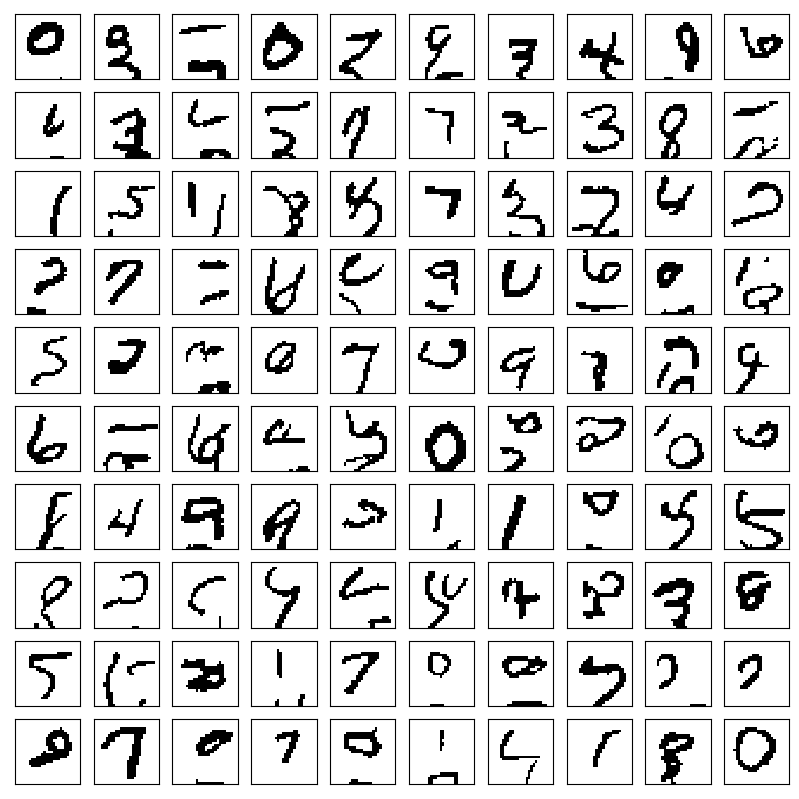

In [ ]:
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        logits = gated_pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

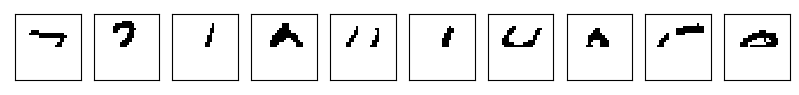

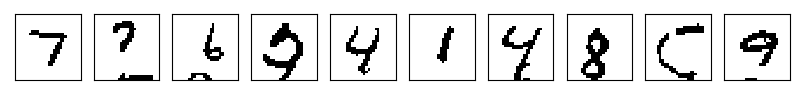

In [ ]:
# Filling occluded images
occlude_start_row = 14
num_generated_images = 10
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = gated_pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

Finally, we sampled some images from the trained model. First, we sampled from scratch, then we completed images partially occluded.

